This colab contains 2 types of CycleGAN namely u-net generator and resnet generator. 

**Evaluation**

We employ both human based and metrics based evaluation metrics approach. 
The code below uses evaluation metrics approach, which will be covered in more dtails in the report.



In [1]:
# generated images and metrics will be saved on your Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Import necessary python modules

In [2]:
!pip install tensorflow-addons

import os
import time
import datetime

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
from IPython.display import clear_output
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
# toggle between resnet and u-net implementation
is_unet = True

# choose either tensorflow dataset or own dataset
use_own_dataset = True

Import training data

In [4]:
image_path = '/content/gdrive/My Drive/data'

train_A, train_B, test_A, test_B = None, None, None, None

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [256, 256])

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

if use_own_dataset:
  train_A = tf.data.Dataset.list_files(str('{}/trainB/*.jpg'.format(image_path)), shuffle=False)
  train_B = tf.data.Dataset.list_files(str('{}/trainA/*.jpg'.format(image_path)), shuffle=False)

  test_A = tf.data.Dataset.list_files(str('{}/testB/*.jpg'.format(image_path)), shuffle=False)
  test_B = tf.data.Dataset.list_files(str('{}/testA/*.jpg'.format(image_path)), shuffle=False)

  train_A = train_A.map(process_path, num_parallel_calls=AUTOTUNE)
  train_B = train_B.map(process_path, num_parallel_calls=AUTOTUNE)

  test_A = test_A.map(process_path, num_parallel_calls=AUTOTUNE)
  test_B = test_B.map(process_path, num_parallel_calls=AUTOTUNE)

else:
  # NOTE: tfds will take a while to download the dataset
  dataset, metadata = tfds.load('cycle_gan/vangogh2photo',
                              with_info=True, as_supervised=True)
  train_A, train_B = dataset['trainB'], dataset['trainA']
  test_A, test_B = dataset['testB'], dataset['testA']

Process training data with data augmentation

In [5]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1 # we are using instance normalisation hence batch size of 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

def random_crop(image):
  cropped_image = tf.image.random_crop(
    image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image, label=None):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image, label=None):
  image = normalize(image)
  return image

In [6]:
train_A = train_A.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_B = train_B.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_A = test_A.cache().map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_B = test_B.cache().map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Generate building blocks needed for CycleGAN

In [7]:
class ReflectionPadding2D(tf.keras.layers.Layer):
  """ReflectionPadding2D pad input tensor with its reflected value 
  (https://keras.io/examples/generative/cyclegan/)."""
  def __init__(self, padding=(1, 1), **kwargs):
    self.padding = tuple(padding)
    super(ReflectionPadding2D, self).__init__(**kwargs)

  def get_config(self):
    config = super(ReflectionPadding2D, self).get_config().copy()
    config.update({
            'padding': self.padding
        })
    return config

  def call(self, input_tensor, mask=None):
    padding_width, padding_height = self.padding
    padding_tensor = [
      [0, 0],
      [padding_height, padding_height],
      [padding_width, padding_width],
      [0, 0],
    ]
    return tf.pad(input_tensor, padding_tensor, mode="REFLECT")

In [8]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def get_config(self):
    config = super(InstanceNormalization, self).get_config().copy()
    config.update({
            'epsilon': self.epsilon,
        })
    return config

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

In [9]:
def downsample(filters, size, apply_norm=True):
  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    result.add(InstanceNormalization())
    # result.add(tfa.layers.InstanceNormalization(gamma_initializer=initializer))

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [10]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  result.add(InstanceNormalization())
  # result.add(tfa.layers.InstanceNormalization(gamma_initializer=initializer))

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [11]:
def residual_block(x, kernel_size=(3, 3), strides=(1, 1), padding="valid"):
  initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

  filters = x.shape[-1]
  input_tensor = x

  
  x = ReflectionPadding2D()(input_tensor)
  x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, 
                                    kernel_initializer=initializer, 
                                    padding=padding, use_bias=False)(x)
  x = InstanceNormalization()(x)
  # x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
  x = tf.keras.layers.ReLU()(x)

  x = ReflectionPadding2D()(x)
  x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, 
                                    kernel_initializer=initializer, 
                                    padding=padding, use_bias=False)(x)
  x = InstanceNormalization()(x)
  # x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
  x = tf.keras.layers.add([input_tensor, x])
  return x

Generate generators and discriminator

In [12]:
def unet_generator():
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
    Model derived from https://www.tensorflow.org/tutorials/generative/pix2pix
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  down_stack = [
      downsample(64, 4, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4),  # (bs, 64, 64, 128)
      downsample(256, 4),  # (bs, 32, 32, 256)
      downsample(512, 4),  # (bs, 16, 16, 512)
      downsample(512, 4),  # (bs, 8, 8, 512)
      downsample(512, 4),  # (bs, 4, 4, 512)
      downsample(512, 4),  # (bs, 2, 2, 512)
      downsample(512, 4),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4),  # (bs, 16, 16, 1024)
      upsample(256, 4),  # (bs, 32, 32, 512)
      upsample(128, 4),  # (bs, 64, 64, 256)
      upsample(64, 4),  # (bs, 128, 128, 128)
  ]

  last = tf.keras.layers.Conv2DTranspose(
      3, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
def resnet_generator(filters=64, num_downsampling_blocks=2, num_residual_blocks=9, num_upsample_blocks=2):
  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = ReflectionPadding2D(padding=(3, 3))(inputs)
  # x = inputs
  x = tf.keras.layers.Conv2D(filters, (7, 7), kernel_initializer=initializer)(x)
  x = InstanceNormalization()(x)
  # x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
  x = tf.keras.layers.ReLU()(x)

  # downsampling
  for _ in range(num_downsampling_blocks):
    filters *= 2
    x = downsample(filters, 4)(x)

  # residual blocks
  for _ in range(num_residual_blocks):
    x = residual_block(x)

  # upsampling
  for _ in range(num_upsample_blocks):
    filters //= 2
    x = upsample(filters, 4)(x)

  # final block
  x = ReflectionPadding2D(padding=(3, 3))(x)
  x = tf.keras.layers.Conv2D(3, (7, 7))(x)
  x = tf.keras.layers.Activation("tanh")(x)

  model = tf.keras.models.Model(inputs=inputs, outputs=x)
  return model

In [14]:
def discriminator(target=True):
  """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).
  Model derived from https://www.tensorflow.org/tutorials/generative/pix2pix
  """

  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  
  norm1 = InstanceNormalization()(conv)
  # norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)

Create generators and discriminator 

In [15]:
generator_g, generator_f = None, None

if is_unet:
  generator_g = unet_generator()
  generator_f = unet_generator()
else:
  generator_g = resnet_generator()
  generator_f = resnet_generator()

discriminator_x = discriminator(target=False)
discriminator_y = discriminator(target=False)

Prepare loss functions 

In [16]:
# Loss functions
LAMBDA = 10 # as stated in cycleGAN paper

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

# NOTE: use to preserve colour in generated photo. 
# Optional if colour accuracy is not important.
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialise optimizer

In [17]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Initialise checkpoint

In [18]:
checkpoint_path = '/content/gdrive/My Drive/checkpoint'

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5) 

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

Create image generator to visualise results

In [19]:
def generate_images(model, test_input, save=False, name=None):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1,2,i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

  if save:
    plt.imsave('/content/gdrive/My Drive/image_results/{}.jpeg'.format(name), 
               (display_list[1] * 0.5 + 0.5).numpy())

Set training EPOCH

In [20]:
EPOCHS = 80

Set up training step

In [21]:
@tf.function
def train_step(real_x, real_y):

  with tf.GradientTape(persistent=True) as tape:
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
    total_gen_g_loss = gen_g_loss + total_cycle_loss
    total_gen_f_loss = gen_f_loss + total_cycle_loss

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                          generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                          generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                              discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                              discriminator_y.trainable_variables)
    
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                              generator_g.trainable_variables))
    
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                              generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, 
                                                 discriminator_x.trainable_variables))
    
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                  discriminator_y.trainable_variables))
    
    return gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss, total_cycle_loss, total_gen_g_loss, total_gen_f_loss

Run training 

In [22]:
# for visualisation of training purpose
sample_A = next(iter(train_A))

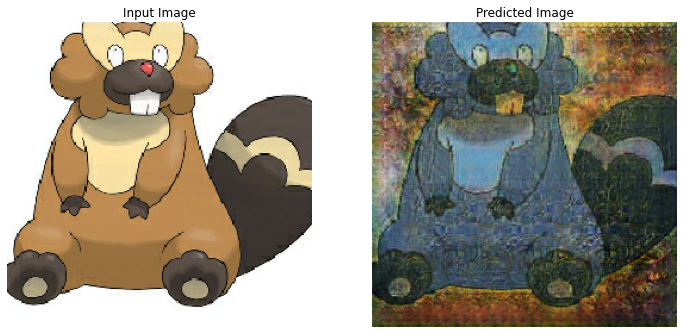

Time taken for epoch 40 is 65.35730266571045 sec



In [23]:
log_dir = '/content/gdrive/MyDrive/logs/'
datetime_string = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime_string)

for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_A, train_B)):
    gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss, total_cycle_loss, total_gen_g_loss, total_gen_f_loss = train_step(image_x, image_y)
    if n % 10 == 0:
      print('.', end='')

      # write to logs
      with summary_writer.as_default():
        tf.summary.scalar('gen_g_loss', gen_g_loss, step=n//10)
        tf.summary.scalar('gen_f_loss', gen_f_loss, step=n//10)

        tf.summary.scalar('disc_x_loss', disc_x_loss, step=n//10)
        tf.summary.scalar('disc_y_loss', disc_y_loss, step=n//10)

        tf.summary.scalar('total_cycle_loss', total_cycle_loss, step=n//10)
        tf.summary.scalar('total_gen_g_loss', total_gen_g_loss, step=n//10)
        tf.summary.scalar('total_gen_f_loss', total_gen_f_loss, step=n//10)

    
    n += 1

  clear_output(wait=True)

  name = None
  if is_unet:
    name = 'unet-{}-epoch-{}'.format(datetime_string, epoch + 1)
  else:
    name = 'resnet-{}-epoch-{}'.format(datetime_string, epoch + 1)
  
  generate_images(generator_g, sample_A, save=True, name=name)


  if(epoch + 1) % 10 == 0:
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

  print('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                     time.time()-start))

Visualise results

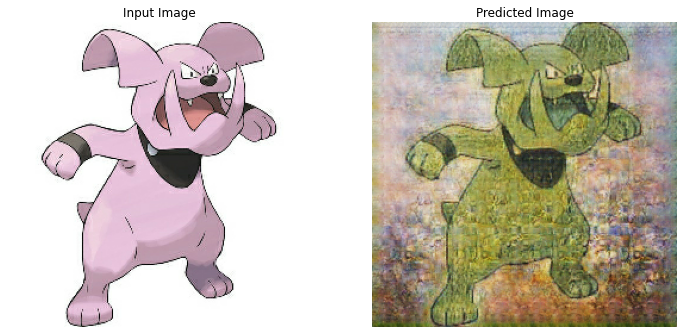

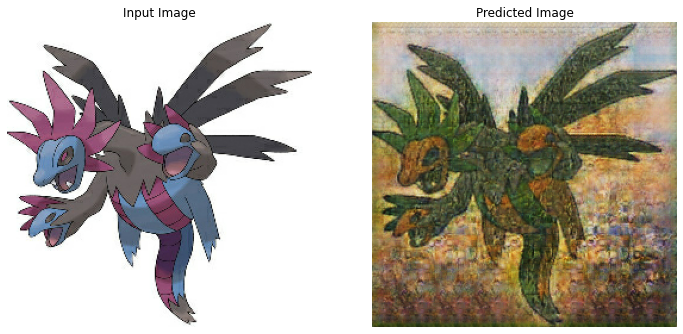

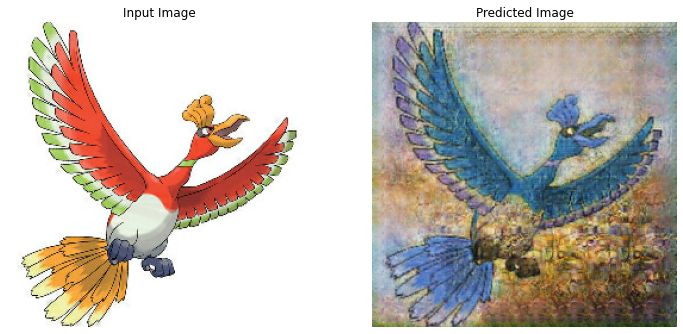

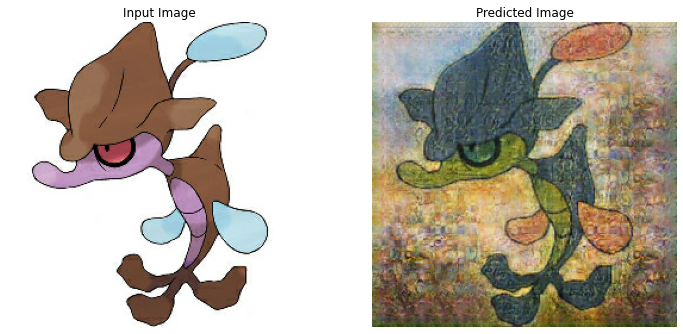

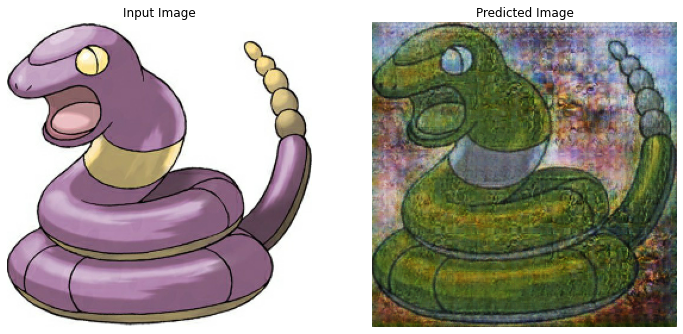

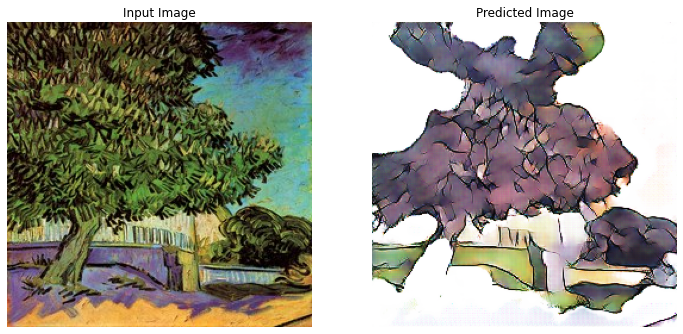

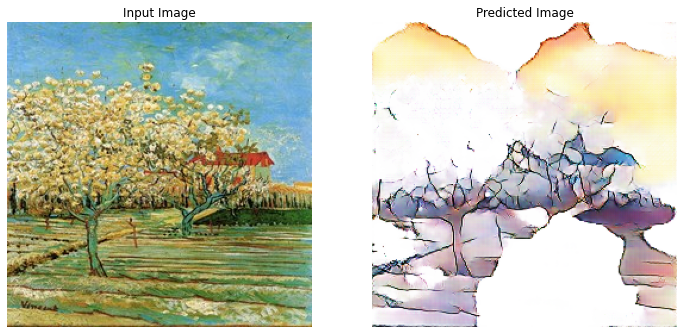

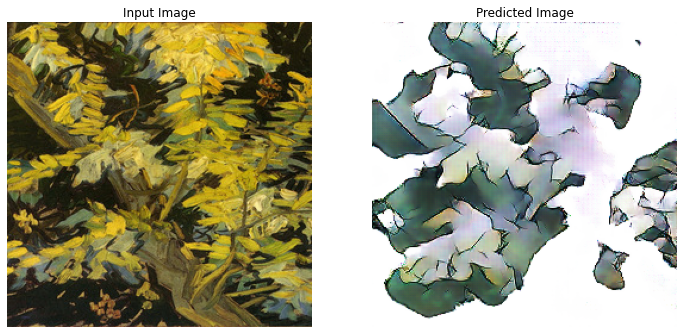

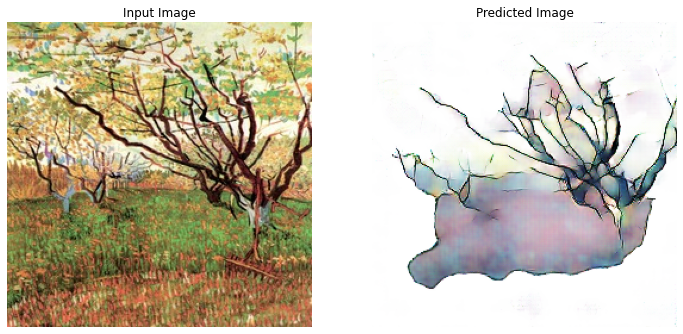

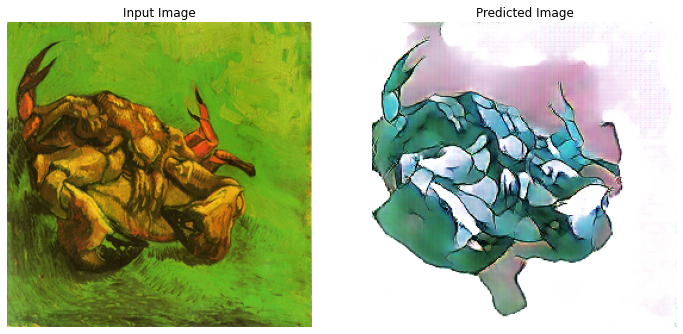

In [24]:
for inp in test_A.take(5):
  generate_images(generator_g, inp)

for inp in test_B.take(5):
  generate_images(generator_f, inp)

Save models

In [25]:
gen_g_model_path = '/content/gdrive/My Drive/model/cyclegan-model-to-drawing'
generator_g.save(gen_g_model_path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/model/cyclegan-model-to-drawing/assets


In [ ]:
gen_f_model_path = '/content/gdrive/My Drive/model/cyclegan-model-to-photo'
generator_f.save(gen_f_model_path)

In [27]:
# convert models to tensorflow javascript version
!pip install tensorflowjs
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(generator_g, '/content/gdrive/My Drive/js_model/generator_g')
tfjs.converters.save_keras_model(generator_f, '/content/gdrive/My Drive/js_model/generator_f')